In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
import torch

In [2]:
df_train = glob.glob(os.path.join("FD00*_df_train.csv"))
df_test = glob.glob(os.path.join("FD00*_df_test.csv"))

In [3]:
train = pd.read_csv(df_train[0], index_col=0)
test = pd.read_csv(df_test[0], index_col=0)

In [4]:
train['RUL'] = max(train['time_in_cycles']) - train['time_in_cycles']
test['RUL'] = max(test['time_in_cycles']) - test['time_in_cycles']

In [5]:
train.drop(columns=['time_in_cycles'], inplace=True)
test.drop(columns=['time_in_cycles'], inplace=True)

In [6]:
train_engine = train.groupby('engine_no').transform(lambda x: max(x) - x)
test_engine = test.groupby('engine_no').transform(lambda x: max(x) - x)

In [7]:
train_engine.drop(columns=['op_setting_1', 'op_setting_2', 'op_setting_3'], inplace=True)
test_engine.drop(columns=['op_setting_1', 'op_setting_2', 'op_setting_3'], inplace=True)

In [8]:
train_engine['engine_no'] = train['engine_no']
test_engine['engine_no'] = test['engine_no']

# 預先處理資料集

In [9]:
train_data = train_engine.dropna(axis='columns')
test_data = test_engine.dropna(axis='columns')

In [10]:
train_rul = train_data['RUL']
test_rul = test_data['RUL']

In [11]:
del train_data['RUL']
del test_data['RUL']

#### 切分: 測試、驗證、訓練

* 打包測試集

In [12]:
from sklearn.model_selection import train_test_split
X_train, Y_train, X_test, Y_test = train_test_split(train_data, train_rul, test_size=0.2)

In [13]:
X_train = torch.tensor(X_train.values)
Y_train = torch.tensor(Y_train.values)
X_test = torch.tensor(np.array(X_test))
Y_test = torch.tensor(np.array(Y_test))
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

torch.Size([16504, 22])
torch.Size([16504])
torch.Size([4127, 22])
torch.Size([4127])


In [14]:
from torch.utils.data import TensorDataset, DataLoader
X_dataset = TensorDataset(X_train, X_test)
Y_dataset = TensorDataset(Y_train, Y_test)
train_loader = DataLoader(X_dataset, batch_size=22, shuffle=True)
test_loader = DataLoader(Y_dataset, batch_size=22, shuffle=True)

* 打包測試集

In [15]:
train_x, train_y, val_x, val_y = train_test_split(test_data, test_rul, test_size=0.2)

In [16]:
train_x = torch.tensor(train_x.values)
train_y = torch.tensor(train_y.values)
val_x = torch.tensor(np.array(val_x))
val_y = torch.tensor(np.array(val_y))
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

torch.Size([10476, 22])
torch.Size([10476])
torch.Size([2620, 22])
torch.Size([2620])


In [17]:
from torch.utils.data import TensorDataset, DataLoader
test_X_dataset = TensorDataset(train_x, val_x)
test_Y_dataset = TensorDataset(train_y, val_y)
val_train_loader = DataLoader(X_dataset, batch_size=22, shuffle=True)
val_test_loader = DataLoader(Y_dataset, batch_size=22, shuffle=True)

# 建立Bnn 並開始訓練

In [18]:
import torchbnn as bnn

class BayesianNet(torch.nn.Module):
    def __init__(self):
        super(BayesianNet, self).__init__()
        self.hid = bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features=22, out_features=100)
        self.oupt = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,in_features=100, out_features=10)
    
    def forward(self, x):
        z = torch.relu(self.hid(x))
        z = self.oupt(z)
        return z

In [19]:
net = BayesianNet()

In [20]:
bat_size = 4
max_epochs = 100
ep_log_interval = 10

ce_loss = torch.nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)

In [21]:
print("\nbat_size = %3d " % bat_size)
print("loss = highly customized ")
print("optimizer = Adam 0.01")
print("max_epochs = %3d " % max_epochs)
print("\nStarting training")


bat_size =   4 
loss = highly customized 
optimizer = Adam 0.01
max_epochs = 100 

Starting training


In [22]:
def validate(net, val_loader, num_classes):
    net.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(torch.float)
            labels = labels.view(-1).to(torch.long).clamp(0, num_classes - 1)

            outputs = net(inputs)
            _, preds = outputs.max(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    return total_correct / total_samples

In [23]:
train_deviance_values = []
num_classes = 10
for epoch in range(max_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(torch.float)
        labels = labels.view(-1).to(torch.long).clamp(0, num_classes - 1)
        
        optimizer.zero_grad()
        outputs = net(inputs)
    
        ce_loss_value = ce_loss(outputs, labels)
        kl_loss_value = kl_loss(net)
        loss_value = ce_loss_value + kl_loss_value

        loss_value.backward()
        optimizer.step()

        deviance = loss_value.item()
        train_deviance_values.append(deviance)

    if epoch % ep_log_interval == 0:
        val_acc = validate(net, test_loader, num_classes)
        print(f'Epoch {epoch}: CE Loss = {ce_loss_value.item():.4f}, KL Loss = {kl_loss_value.item():.4f}, Total Loss = {loss_value.item():.4f}, Validation Accuracy = {val_acc:.4f}')


Epoch 0: CE Loss = 0.0003, KL Loss = 0.2111, Total Loss = 0.2114, Validation Accuracy = 0.9511
Epoch 10: CE Loss = 0.0935, KL Loss = 0.1818, Total Loss = 0.2753, Validation Accuracy = 0.9506
Epoch 20: CE Loss = 0.1233, KL Loss = 0.1800, Total Loss = 0.3033, Validation Accuracy = 0.9503
Epoch 30: CE Loss = 0.0164, KL Loss = 0.1771, Total Loss = 0.1936, Validation Accuracy = 0.9518
Epoch 40: CE Loss = 0.0593, KL Loss = 0.1630, Total Loss = 0.2222, Validation Accuracy = 0.9402
Epoch 50: CE Loss = 0.0376, KL Loss = 0.1837, Total Loss = 0.2214, Validation Accuracy = 0.9477
Epoch 60: CE Loss = 0.0442, KL Loss = 0.1850, Total Loss = 0.2292, Validation Accuracy = 0.9489
Epoch 70: CE Loss = 1.1663, KL Loss = 0.1983, Total Loss = 1.3646, Validation Accuracy = 0.9409
Epoch 80: CE Loss = 0.0202, KL Loss = 0.2008, Total Loss = 0.2210, Validation Accuracy = 0.9525
Epoch 90: CE Loss = 0.5774, KL Loss = 0.2021, Total Loss = 0.7795, Validation Accuracy = 0.9520


In [24]:
def get_prediction_scores(net, data_loader):
    net.eval()
    scores = []
    labels = []

    with torch.no_grad():
        for inputs, target in data_loader:
            inputs = inputs.to(torch.float)
            scores.extend(net(inputs).squeeze().tolist())
            labels.extend(target.tolist())

    return scores, labels

test_scores, test_labels = get_prediction_scores(net, test_loader)

# 驗證模型

In [25]:
from sklearn.metrics import mean_squared_error
y_true = np.array(train_rul)
y_pred = np.array(test_labels)
print(f'RMSE = {mean_squared_error(Y_test, y_pred):.4f}')

RMSE = 9490.0107


# 測試模型

In [26]:
test_deviance_values = []
num_classes = 10
for epoch in range(max_epochs):
    for inputs, labels in val_train_loader:
        inputs = inputs.to(torch.float)
        labels = labels.view(-1).to(torch.long).clamp(0, num_classes - 1)
        
        optimizer.zero_grad()
        outputs = net(inputs)
    
        ce_loss_value = ce_loss(outputs, labels)
        kl_loss_value = kl_loss(net)
        loss_value = ce_loss_value + kl_loss_value

        loss_value.backward()
        optimizer.step()

        deviance = loss_value.item()
        test_deviance_values.append(deviance)

    if epoch % ep_log_interval == 0:
        val_acc = validate(net, val_test_loader, num_classes)
        print(f'Epoch {epoch}: CE Loss = {ce_loss_value.item():.4f}, KL Loss = {kl_loss_value.item():.4f}, Total Loss = {loss_value.item():.4f}, Validation Accuracy = {val_acc:.4f}')


Epoch 0: CE Loss = 0.0489, KL Loss = 0.2209, Total Loss = 0.2698, Validation Accuracy = 0.9402
Epoch 10: CE Loss = 0.0538, KL Loss = 0.1745, Total Loss = 0.2283, Validation Accuracy = 0.9530
Epoch 20: CE Loss = 0.0139, KL Loss = 0.1821, Total Loss = 0.1960, Validation Accuracy = 0.9530
Epoch 30: CE Loss = 0.0937, KL Loss = 0.1579, Total Loss = 0.2516, Validation Accuracy = 0.9508
Epoch 40: CE Loss = 0.0710, KL Loss = 0.2908, Total Loss = 0.3618, Validation Accuracy = 0.9513
Epoch 50: CE Loss = 0.0143, KL Loss = 0.1811, Total Loss = 0.1954, Validation Accuracy = 0.9528
Epoch 60: CE Loss = 0.0725, KL Loss = 0.2540, Total Loss = 0.3265, Validation Accuracy = 0.9440
Epoch 70: CE Loss = 1.5588, KL Loss = 0.2104, Total Loss = 1.7691, Validation Accuracy = 0.9433
Epoch 80: CE Loss = 2.1025, KL Loss = 0.1643, Total Loss = 2.2668, Validation Accuracy = 0.9520
Epoch 90: CE Loss = 0.0301, KL Loss = 0.1735, Total Loss = 0.2036, Validation Accuracy = 0.9530


In [27]:
val_scores, val_labels = get_prediction_scores(net, val_test_loader)

In [28]:
from sklearn.metrics import mean_squared_error
y_true = np.array(test_rul)
y_pred = np.array(val_labels)
print(f'RMSE = {mean_squared_error(Y_test, y_pred):.4f}')

RMSE = 9643.2770


In [29]:
deviance = pd.DataFrame({
    'Train deviance' : train_deviance_values,
    'Test deviance' : test_deviance_values
})

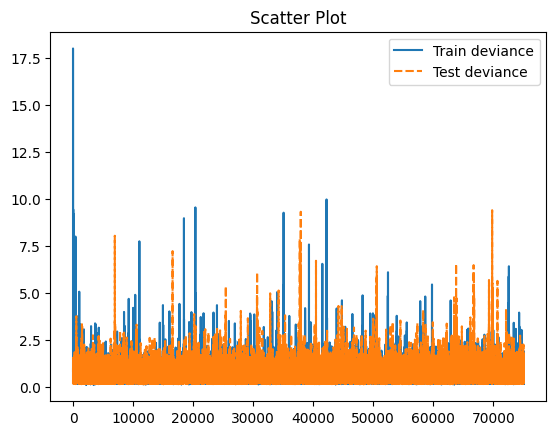

In [30]:
sns.lineplot(data = deviance)
plt.title("Scatter Plot")
plt.show()